# Generate final LLM DVs per tasl

Starting point:
- dataset with itemlevel values for each task for each model

Goal:
- calculate the final DVs (orient at how Frey caculated the DVs from the item values of the participants)

In [2]:
# packages and data

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns
import ast


# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")

### AUDIT SCALE

In [3]:
# extract AUDIT experiment, and sum up score_top_n_top_n overall
AUDIT_SUB= all_data[all_data["experiment"] == "AUDIT scale"]
AUDIT_DV_DF = AUDIT_SUB.groupby(["model"])["score_top_n"].sum().reset_index()

# extract item 1 and if any model scored 0 (not possible, but theoretically correct)
item1 = AUDIT_SUB[AUDIT_SUB["item"] == "1"][["model", "score_top_n"]]
item1 = item1.rename(columns={"score_top_n": "item1_score_top_n"})
AUDIT_DV_DF = AUDIT_DV_DF.merge(item1, on="model")

# if any model scored 0, 0 stays, else add 1 and compute the log, that is the DV of AUDIT (as described in Frey)
AUDIT_DV_DF["score_top_n"] = np.where(
    AUDIT_DV_DF["item1_score_top_n"] == 0,
    0,
    np.log(AUDIT_DV_DF["score_top_n"] + 1)
)

# rename column to concat with rest of data
AUDIT_DV_DF = AUDIT_DV_DF.rename(columns={"score_top_n": "AUDIT"})


### BARRAT SCALE
- if I understand it correctly (no docu) sum per subscale

In [4]:
BARRAT_SUB= all_data[all_data["experiment"] == "BARRAT scale"]
BARRAT_DV_DF = BARRAT_SUB.groupby(["model", "category"])["score_top_n"].sum().reset_index()
BARRAT_DV_DF = BARRAT_DV_DF.pivot(index="model", columns="category", values="score_top_n")


In [5]:
# add_new_df
DV_data = pd.merge(AUDIT_DV_DF[["model", "AUDIT"]], 
                    BARRAT_DV_DF, 
                    on="model",
                    how = "outer")


### CARE SCALE

- binned factors, sum up each category and see in which level (in level_stats) it falls 

In [6]:
CARE_SUB= all_data[all_data["experiment"] == "CARE scale"]
CARE_DV_DF = CARE_SUB.groupby(["model", "category"])["score_top_n"].sum().reset_index()
# recode according to defined categories (Frey et al)
def recode_care(row):
    if row['category'] == 'CAREw':  # carework
        if 0 <= row['score_top_n'] < 3:
            return 0
        elif 3 <= row['score_top_n'] < 8:
            return 1
        elif 8 <= row['score_top_n'] < 17:
            return 2
        else:  # 17 and above
            return 3
    elif row['category'] == 'CAREa':  # careaggr
        if row['score_top_n'] == 0:
            return 0
        elif 1 <= row['score_top_n'] < 5:
            return 1
        else:  # 5 and above
            return 2
    elif row['category'] == 'CAREs':  # caresex
        if 0 <= row['score_top_n'] < 2:
            return 0
        elif 2 <= row['score_top_n'] < 8:
            return 1
        else:  # 8 and above
            return 2
        
CARE_DV_DF['score_top_n'] = CARE_DV_DF.apply(recode_care, axis=1)

# pivot longer for final form 
CARE_DV_DF = CARE_DV_DF.pivot(index="model", columns="category", values="score_top_n")


In [7]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    CARE_DV_DF,
    on="model",
    how="outer"
)

### DAST SCALE
- It should be a binned factor:
0 = 0,
1 = 1-18

But when I do that, no discrimination/variation at all, therefore leave it out for now and ask Dirk

In [8]:
DAST_SUB= all_data[all_data["experiment"] == "DAST scale"]
DAST_DV_DF = DAST_SUB.groupby(["model"])["score_top_n"].sum().reset_index()


In [9]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DAST_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "DAST"}),
    on="model",
    how="outer"
)

### DM SCALE
- sum was computed from the following values in each item: 0=never, 1=once or twice, 2=several times, 0=not applicable (mapping done in postprocessing)
- LLM probabilities were already weighed with these values, therefore we can simply sum up

In [10]:
DM_SUB= all_data[all_data["experiment"] == "Dm scale"]
DM_DV_DF = DM_SUB.groupby(["model"])["score_top_n"].sum().reset_index() 


In [11]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DM_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "DM"}),
    on="model",
    how="outer"
)

### DOSPERT SCALE
- if I understand it correctly (no docu) mean per subscale

In [12]:
DOSPERT_SUB= all_data[all_data["experiment"] == "DOSPERT scale"]
DOSPERT_DV_DF = DOSPERT_SUB.groupby(["model", "category"])["score_top_n"].mean().reset_index()
DOSPERT_DV_DF = DOSPERT_DV_DF.pivot(index="model", columns="category", values="score_top_n")


# rename column to concat with rest of data
DOSPERT_DV_DF = DOSPERT_DV_DF.rename(columns={
    "Ethical": "Deth",
    "Gambling": "Dgam",
    "Health": "Dhea",
    "Investment": "Dinv",
    "Recreational": "Drec",
    "Social": "Dsoc",

    })



In [13]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DOSPERT_DV_DF,
    on="model",
    how="outer"
)

### FTND SCALE
- binned factor of sum score_top_n (I think)
- same issue as with DAST, since level 0 and 1 are seperated from 0 to 1 till end, would be no discrimination, leaving as is

In [14]:
FTND_SUB= all_data[all_data["experiment"] == "FTND scale"]
FTND_DV_DF = FTND_SUB.groupby(["model"])["score_top_n"].sum().reset_index()


In [15]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    FTND_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "FTND"}),
    on="model",
    how="outer"
)

### GABS SCALE
- binned factor of sum score_top_n (think again)
- weird: in Frey et al, they divide into dfactors: 0 = up to 15, 1 = 15 to 60
- they probably do some form of refactoring of the item 2-16 (since they are going from 1-5or so) (because summing up while using different scales, weird)
- also leaving as is for now

In [16]:
GABS_SUB= all_data[all_data["experiment"] == "GABS scale"]
GABS_DV_DF = GABS_SUB.groupby(["model"])["score_top_n"].sum().reset_index()


In [17]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    GABS_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "GABS"}),
    on="model",
    how="outer"
)

### PG SCALE
- again binned factor of sum score
- but because the levels are 0=0, 1=1-36, would not make sense here

In [18]:
PG_SUB= all_data[all_data["experiment"] == "PG scale"]
PG_DV_DF = PG_SUB.groupby(["model"])["score_top_n"].sum().reset_index()


In [19]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    PG_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "PG"}),
    on="model",
    how="outer"
)

### PRI SCALE
- no docu, nothing, I have NO IDEA how to get to a sensible score in that task
- using means for now

In [20]:
PRI_SUB= all_data[all_data["experiment"] == "PRI scale"]
PRI_DV_DF = PRI_SUB.groupby(["model", "category"])["score_top_n"].mean().reset_index()
PRI_DV_DF = PRI_DV_DF.pivot(index="model", columns="category", values="score_top_n")


# rename column to concat with rest of data
PRI_DV_DF = PRI_DV_DF.rename(columns={
    "certainty": "PRI_certainty",
    "decision": "PRI_decision",

    })

In [21]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    PRI_DV_DF,
    on="model",
    how="outer"
)

### SOEP SCALE

- simply stays the same, every value in one sub category is one value

In [22]:
SOEP_SUB= all_data[all_data["experiment"] == "SOEP scale"]
SOEP_DV_DF = SOEP_SUB.pivot(index="model", columns="category", values="score_top_n")

In [23]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SOEP_DV_DF,
    on="model",
    how="outer"
)

### SSSV SCALE

- I guess summing over sub categories?!

In [24]:
SSSV_SUB= all_data[all_data["experiment"] == "SSSV scale"]
SSSV_DV_DF = SSSV_SUB.groupby(["model", "category"])["score_top_n"].sum().reset_index()
SSSV_DV_DF = SSSV_DV_DF.pivot(index="model", columns="category", values="score_top_n")


In [25]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    SSSV_DV_DF,
    on="model",
    how="outer"
)

### BART TASK

- mean number of pumps over trials (items)

In [26]:
BART_SUB= all_data[all_data["experiment"] == "BART task"]
BART_DV_DF = BART_SUB.groupby(["model"])["score_top_n"].mean().reset_index()
#BART_DV_DF

In [27]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    BART_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "BART"}),
    on="model",
    how="outer"
)

### CCT TASK
- sum of all cards drawn (scores of all items per person summed up)

In [28]:
CCT_SUB= all_data[all_data["experiment"] == "CCT task"]
CCT_DV_DF = CCT_SUB.groupby(["model"])["score_top_n"].sum().reset_index()
#CCT_DV_DF

In [29]:
 # add_new_df
DV_data = pd.merge(
    DV_data,
    CCT_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "CCT"}),
    on="model",
    how="outer"
)

### DFD TASK

- DFD is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [30]:
DFD_SUB= all_data[all_data["experiment"] == "DFD task"]
DFD_DV_DF = DFD_SUB.groupby(["model"])["score_top_n"].mean().reset_index()
#DFD_DV_DF

In [31]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFD_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "DFD"}),
    on="model",
    how="outer"
)

### DFE TASK
- same as DFD
- DFE re is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [32]:
DFE_SUB= all_data[all_data["experiment"] == "DFE task"]
DFE_DV_DF = DFE_SUB.groupby(["model"])["score_top_n"].mean().reset_index()
#DFE_DV_DF

In [33]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFE_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "DFE"}),
    on="model",
    how="outer"
)

### LOT TASK

- mean i.e. proportion of risky choices out of the 25 trials.

In [34]:
LOT_SUB= all_data[all_data["experiment"] == "LOT task"]
LOT_DV_DF = LOT_SUB.groupby(["model"])["score_top_n"].mean().reset_index()
#LOT_DV_DF

In [35]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    LOT_DV_DF[["model", "score_top_n"]].rename(columns={"score_top_n": "LOT"}),
    on="model",
    how="outer"
)

### MPL TASK
- switching point:
    - only the first of all rounds is taken into consideration
    - there it is looked at the switching point (the first decision for the riskier choice)

- I will also only consider the first round, look at the scores and round probabilities under 0.5 to 0 and from 0.5 on to 1. 
- then I will define the switching point of a model as the first 1 decision. (=DV)

In [36]:
# filter only MPL data and filter only data for the first round, (since round 2-7 are ignored for the DV)
MPL_SUB= all_data[all_data["experiment"] == "MPL task"]
MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)
MPL_SUB_ROUND_1 = MPL_SUB[MPL_SUB['item'].apply(lambda x: x[0] == 1)]


/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_25695/2303537433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)


In [37]:
# define the switching point by first transforming all scores to 0 or 1 (depends on whether they are bigger than 0.5)
MPL_SUB_ROUND_1["decision"] = np.where(
    MPL_SUB_ROUND_1["score_top_n"] <= 0.5,
    0,
    1
)

#MPL_SUB_ROUND_1.tail(50)

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_25695/2404167858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB_ROUND_1["decision"] = np.where(


In [38]:
# not yet happy with, current sum up technique to simulate switching point
MPL_DV_DF = MPL_SUB_ROUND_1.groupby(["model"])["decision"].sum().reset_index()
#MPL_DV_DF

In [39]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    MPL_DV_DF[["model", "decision"]].rename(columns={"decision": "MPL"}),
    on="model",
    how="outer"
)

## Preliminary Results

In [40]:
DV_data

,model,AUDIT,BISa,BISm,BISn,CAREa,CAREs,CAREw,DAST,DM,...,SSbor,SSdis,SSexp,SStas,BART,CCT,DFD,DFE,LOT,MPL
0,Apertus-70B-Instruct-2509,2.205117,17.958576,24.869790,21.785546,2,1,1,2.223337,20.928813,...,15.943342,16.449311,16.381209,15.413468,35.113553,NaN,0.518680,0.441782,0.501739,2
1,Apertus-8B-Instruct-2509,1.884882,14.716622,25.448990,17.757177,1,0,0,0.572676,13.516819,...,15.586128,12.815115,13.921512,14.630914,32.670649,215.144914,0.465854,0.447288,0.488997,2
2,Falcon-3-10B-Instruct,2.344061,14.425462,23.170056,20.846337,1,2,2,4.282900,9.179057,...,15.201221,12.962398,15.243616,14.912043,23.352448,306.611504,0.428710,0.388713,0.483305,4
3,Falcon-3-1B-Instruct,1.639827,14.165717,19.034320,25.774195,2,0,0,1.684511,21.774000,...,14.732175,15.442783,15.455290,15.720307,30.475715,452.157905,0.488587,0.417470,0.459690,1
4,Falcon-3-7B-Instruct,1.457686,14.833556,24.938909,19.649360,1,0,2,2.855660,19.439761,...,14.487967,13.429054,13.669554,11.913951,17.873157,212.453349,0.430464,0.407209,0.502804,6
5,LFM2-1.2B,2.007478,17.644494,24.772289,24.975119,1,1,0,3.166384,4.576633,...,14.917042,13.019885,15.856254,15.150982,35.950838,433.370224,0.505048,0.447271,0.435325,1
6,LFM2-2.6B,1.960524,12.647457,22.396506,21.262243,1,0,1,4.032702,7.954320,...,14.824866,15.669876,16.078590,16.931197,34.831776,422.887018,0.530147,0.384953,0.423831,1
7,LFM2-8B-A1B,1.606040,14.543748,20.039301,23.185407,1,1,2,4.095567,4.335863,...,14.821906,16.562267,15.663852,17.419452,30.819375,468.085142,0.533755,0.388606,0.517354,2
8,Llama-3.1-70B-Instruct,2.036986,14.365631,24.339842,15.650697,2,2,3,2.061849,9.644630,...,15.332289,13.306199,15.171575,15.496871,20.202080,387.465838,0.428095,0.409430,0.458471,5
9,Llama-3.1-8B-Instruct,2.051750,11.587230,15.918273,20.323097,2,2,3,6.696569,4.699637,...,14.684647,13.284864,15.108193,15.659847,18.967728,334.677572,0.490620,0.440054,0.469967,3


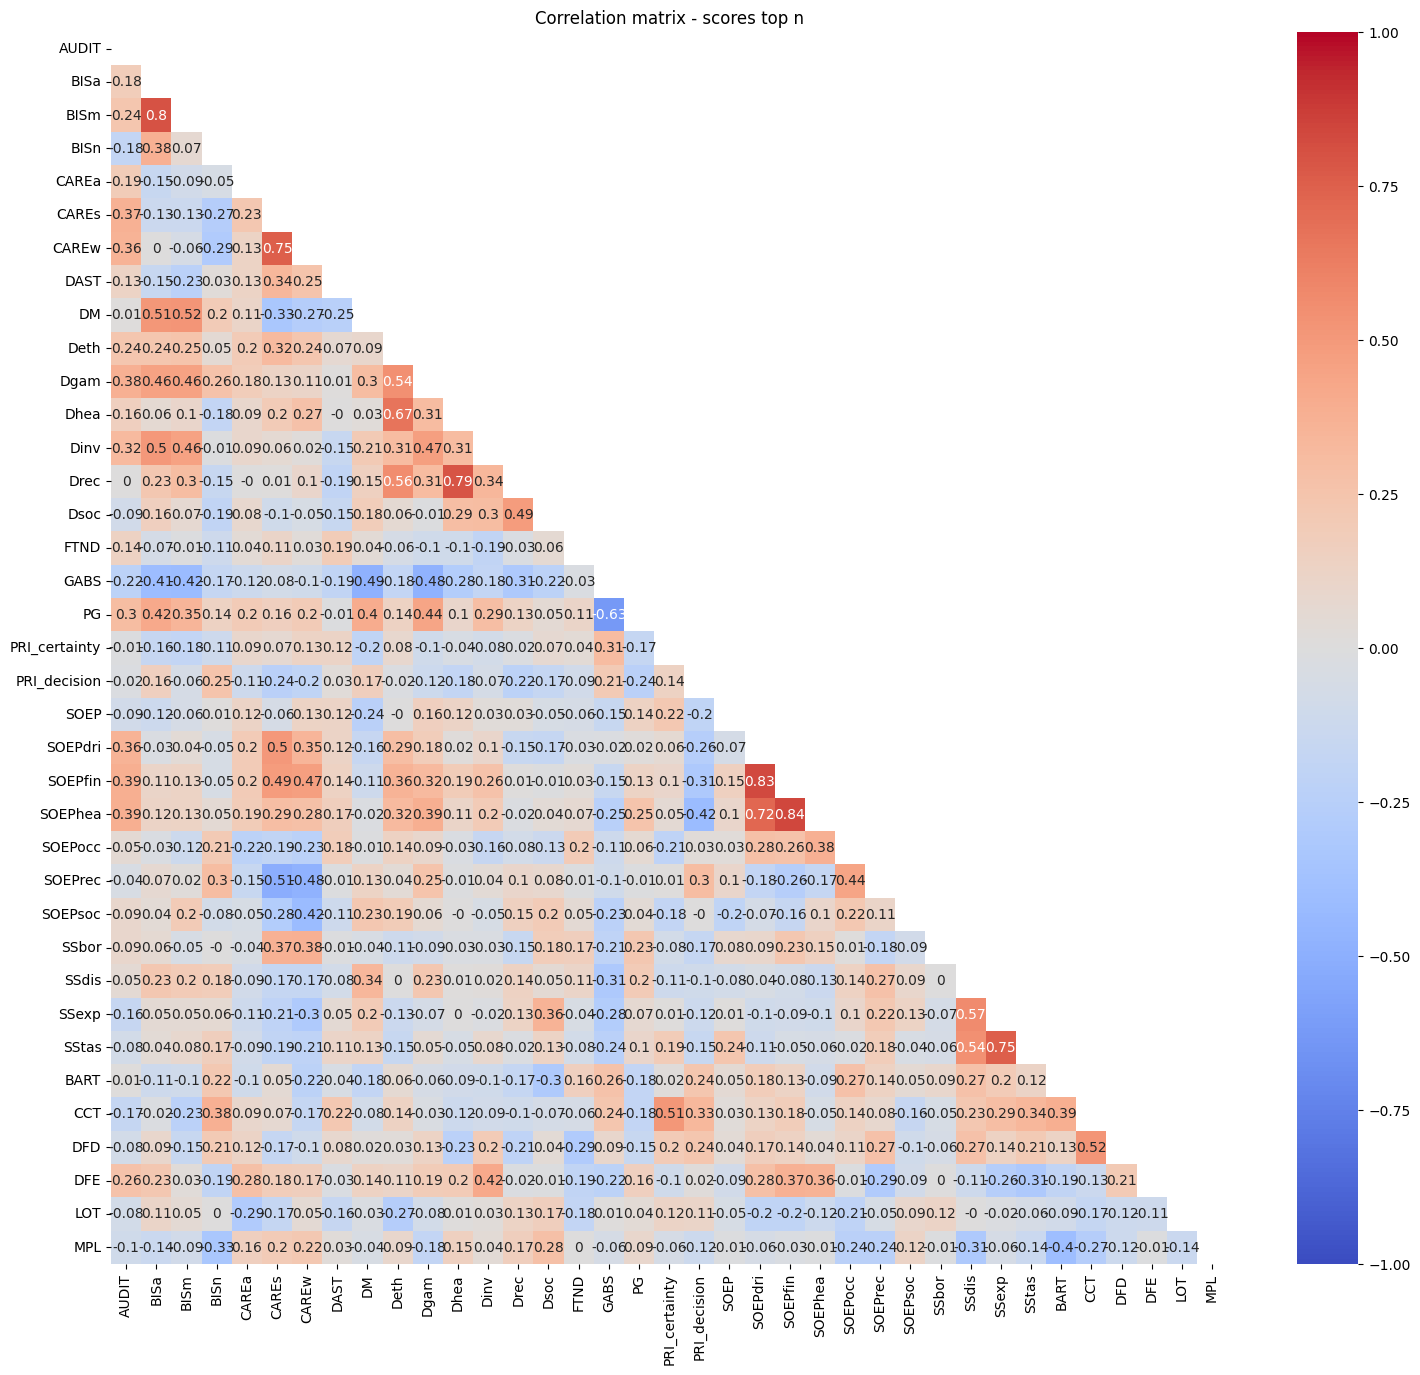

In [41]:
# Compute correlation matrix (only for numeric columns)
numeric_df = DV_data.drop(columns=['model'])
corr = numeric_df.corr().round(2)

# Display it as a heatmap
# plt.figure(figsize=(16, 14))
# sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
# plt.title("Correlation matrix of model scores")
# plt.show()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap with mask
plt.figure(figsize=(18, 16))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation matrix - scores top n")
plt.show()


In [42]:
DV_data.to_csv('processed_data/top_n_final_DVs.csv', index=False)

### Compare top n with all humans weights

In [43]:
# read data
LLM_human_data = pd.read_csv("processed_data/final_Dvs.csv")
data_top_n = pd.read_csv("processed_data/top_n_final_DVs.csv")

In [44]:
common_cols = LLM_human_data.columns.intersection(data_top_n.columns)
common_cols = common_cols.drop("model")
print(common_cols)

Index(['AUDIT', 'BISa', 'BISm', 'BISn', 'CAREa', 'CAREs', 'CAREw', 'DAST',
       'DM', 'Deth', 'Dgam', 'Dhea', 'Dinv', 'Drec', 'Dsoc', 'FTND', 'GABS',
       'PG', 'PRI_certainty', 'PRI_decision', 'SOEP', 'SOEPdri', 'SOEPfin',
       'SOEPhea', 'SOEPocc', 'SOEPrec', 'SOEPsoc', 'SSbor', 'SSdis', 'SSexp',
       'SStas', 'BART', 'CCT', 'DFD', 'DFE', 'LOT', 'MPL'],
      dtype='object')


In [47]:
# same length (i.e. same models)
len(data_top_n) == len(LLM_human_data)

True

In [48]:
correlations = {}

for col in common_cols:
    # align rows by index (model order)
    correlations[col] = LLM_human_data[col].corr(data_top_n[col])

correlations = pd.Series(correlations).sort_values(ascending=False)

corr_df = pd.DataFrame({
    "measure": correlations.index,
    "test_retest_r": correlations.values
})
corr_df

,measure,test_retest_r
0,PG,0.897279
1,LOT,0.884226
2,SOEPhea,0.862784
3,SOEPrec,0.862155
4,CAREw,0.856147
5,SOEPsoc,0.852242
6,SOEPfin,0.837566
7,Dsoc,0.835980
8,Dhea,0.828912
9,Dgam,0.827881
